In [1]:
import argparse
import os
import random

import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

In [2]:
import fastai

In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Text Encoder
Exactly as in pytorch port

In [4]:
import re
import ftfy
import json
import spacy

from tqdm import tqdm

def get_pairs(word):
    """
    Return set of symbol pairs in a word.
    word is represented as tuple of symbols (symbols being variable-length strings)
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs

def text_standardize(text):
    """
    fixes some issues the spacy tokenizer had on books corpus
    also does some whitespace standardization
    """
    text = text.replace('—', '-')
    text = text.replace('–', '-')
    text = text.replace('―', '-')
    text = text.replace('…', '...')
    text = text.replace('´', "'")
    text = re.sub(r'''(-+|~+|!+|"+|;+|\?+|\++|,+|\)+|\(+|\\+|\/+|\*+|\[+|\]+|}+|{+|\|+|_+)''', r' \1 ', text)
    text = re.sub(r'\s*\n\s*', ' \n ', text)
    text = re.sub(r'[^\S\n]+', ' ', text)
    return text.strip()

class TextEncoder(object):
    """
    mostly a wrapper for a public python bpe tokenizer
    """

    def __init__(self, encoder_path, bpe_path):
        self.nlp = spacy.load('en', disable=['parser', 'tagger', 'ner', 'textcat'])
        self.encoder = json.load(open(encoder_path))
        self.decoder = {v:k for k,v in self.encoder.items()}
        merges = open(bpe_path, encoding='utf-8').read().split('\n')[1:-1]
        merges = [tuple(merge.split()) for merge in merges]
        self.bpe_ranks = dict(zip(merges, range(len(merges))))
        self.cache = {}

    def bpe(self, token):
        word = tuple(token[:-1]) + ( token[-1] + '</w>',)
        if token in self.cache:
            return self.cache[token]
        pairs = get_pairs(word)

        if not pairs:
            return token+'</w>'

        while True:
            bigram = min(pairs, key = lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                if word[i] == first and i < len(word)-1 and word[i+1] == second:
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = ' '.join(word)
        if word == '\n  </w>':
            word = '\n</w>'
        self.cache[token] = word
        return word

    def encode(self, texts, verbose=True):
        texts_tokens = []
        if verbose:
            for text in tqdm(texts, ncols=80, leave=False):
                text = self.nlp(text_standardize(ftfy.fix_text(text)))
                text_tokens = []
                for token in text:
                    text_tokens.extend([self.encoder.get(t, 0) for t in self.bpe(token.text.lower()).split(' ')])
                texts_tokens.append(text_tokens)
        else:
            for text in texts:
                text = self.nlp(text_standardize(ftfy.fix_text(text)))
                text_tokens = []
                for token in text:
                    text_tokens.extend([self.encoder.get(t, 0) for t in self.bpe(token.text.lower()).split(' ')])
                texts_tokens.append(text_tokens)
        return texts_tokens

In [5]:
text_encoder = TextEncoder('model/encoder_bpe_40000.json', 'model/vocab_40000.bpe')
encoder = text_encoder.encoder
n_vocab = len(text_encoder.encoder)

# Fast ai loading

In [6]:
from fastai.text import *

/project/fas/radev/jbk54/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [7]:
CLAS_PATH = Path('data/imdb_clas')

In [8]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [9]:
trn_labels = np.load(CLAS_PATH/'tmp'/'lbl_trn.npy')
val_labels = np.load(CLAS_PATH/'tmp'/'lbl_val.npy')

In [10]:
print(tok_trn.size)

25000


# Back to OpenAI

In [11]:
def encode_dataset(*splits, encoder):
    encoded_splits = []
    for split in splits:
        fields = []
        for field in split:
            if isinstance(field[0], str):
                field = encoder.encode(field)
            fields.append(field)
        encoded_splits.append(fields)
    return encoded_splits

Can skip from HERE

In [12]:
print(tok_val[1347])

['\n', 'xbos', 'xfld', '1', 'this', 'movie', 'gives', 'us', 'some', 't_up', 'wwii', 'history', 'along', 'with', 'some', 'touching', 'romance', ',', 'a', 'little', 'fantasy', 'and', 'meaningful', 'emotion', '-', 'and', 'beautiful', 'scenery', '.', 'nicholas', 'cage', 'never', 'fails', 'us', ',', 'and', 'here', 'again', 'does', 'a', 'great', 'job', '.', 'and', 'so', 'do', 'the', 'other', 'principle', 'characters', '.', 'one', 'key', 'charater', ',', 'the', 'physician', '/', 'father', 'played', 'by', 'john', 'hurd', ',', 'delivers', '(', 'to', 'his', 'daughter', ')', 'one', 'of', 'the', 'best', 'definitions', 'of', 'love', 'i', "'ve", 'ever', 'heard', '.', 'some', 'of', 'the', 'events', 'are', 'a', 'bit', 'too', 'coincidental', 'to', 'be', 'real', ',', 'but', 'i', 'excused', 'that', ',', 'knowing', 'that', 'this', 'is', 'partly', 'fairy', 'tale', 'and', 'fantacy', '.', 'my', 'wife', 'and', 'i', 'really', 'liked', 'the', 'film', '.', 'and', 'it', 'is', 'nice', 'to', 'watch', 'people', 'tak

tried to get rid of \n, xbos, xfld, and '1', so i could do it in a manner consistent with openAI's vocabulary

In [13]:
tok_trn = np.asarray([' '.join(s[4:]) for s in tok_trn]) #join in order to make a list of strings in order to use encode_dataset
tok_val = np.asarray([' '.join(s[4:]) for s in tok_val])

In [14]:
print(tok_val[1347])

this movie gives us some t_up wwii history along with some touching romance , a little fantasy and meaningful emotion - and beautiful scenery . nicholas cage never fails us , and here again does a great job . and so do the other principle characters . one key charater , the physician / father played by john hurd , delivers ( to his daughter ) one of the best definitions of love i 've ever heard . some of the events are a bit too coincidental to be real , but i excused that , knowing that this is partly fairy tale and fantacy . my wife and i really liked the film . and it is nice to watch people taking the risks to love the enemy . one man who left the theatre near us said to his wife , " now that 's the way to wage war ! " i think you 'll see what he means when you watch the italian occupiers of this lovely greek island .


In [15]:
((trX, trY), 
 (vaX, vaY)) = encode_dataset((tok_trn, trn_labels), (tok_val, val_labels), encoder=text_encoder)

In [16]:
np.save(CLAS_PATH/'tmp'/'trX.npy', trX)
np.save(CLAS_PATH/'tmp'/'vaX.npy', vaX)
np.save(CLAS_PATH/'tmp'/'trY.npy', trY)
np.save(CLAS_PATH/'tmp'/'vaY.npy', vaY)

until HERE (on a re-run)

In [17]:
trX = np.load(CLAS_PATH/'tmp'/'trX.npy')
vaX = np.load(CLAS_PATH/'tmp'/'vaX.npy')
trY = np.load(CLAS_PATH/'tmp'/'trY.npy')
vaY = np.load(CLAS_PATH/'tmp'/'vaY.npy')

In [18]:
print(trX.shape)
print(trX[0])

(25000,)
[976, 240, 976, 1498, 1573, 6949, 4121, 239, 246, 18769, 1800, 18042, 617, 531, 23075, 239, 1203, 1218, 1428, 487, 11427, 246, 2672, 12808, 4817, 240, 872, 498, 3448, 239, 566, 13856, 3678, 1428, 276, 2229, 240, 525, 535, 599, 481, 7613, 3708, 603, 275, 246, 783, 2672, 12808, 4817, 544, 491, 481, 1736, 239, 520, 2191, 1662, 556, 1007, 3721, 2672, 12808, 4817, 763, 3796, 655, 240, 488, 4482, 5578, 1007, 4817, 239, 481, 4790, 640, 589, 5271, 240, 557, 640, 606, 239, 40477, 655, 640, 246, 2253, 498, 7613, 5555, 10063, 718, 889, 720, 980, 1981, 239, 11571, 640, 1686, 1938, 240, 488, 1892, 485, 1685, 9668, 2393, 1284, 240, 1457, 562, 909, 26992, 498, 775, 1376, 239, 246, 1322, 498, 11571, 11743, 9668, 2060, 488, 1592, 240, 522, 1779, 488, 1592, 240, 488, 4103, 909, 4001, 239, 2751, 481, 6848, 498, 720, 240, 1272, 498, 481, 9668, 640, 1120, 2311, 481, 1164, 4695, 239, 2207, 481, 25093, 6848, 498, 720, 2513, 669, 606, 788, 246, 956, 562, 481, 1420, 720, 240, 606, 1402, 5221, 271, 718

In [19]:
print(trX.dtype)

object


In [20]:
print(trY[:10])

[[0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


In [21]:
encoder['_start_'] = len(encoder)
#encoder['_delimiter_'] = len(encoder)
encoder['_classify_'] = len(encoder)
clf_token = encoder['_classify_']

In [22]:
n_ctx = 512
n_special = 2 #was 3 (no delimiter)
max_len = 254 #it's truncated - if i calculate max_len like I did for RocStories, it gives me a full 512 n_ctx, which can't be handled by my single GPU
n_ctx = min(max([len(x[:max_len]) for x in trX] + [len(x[:max_len]) for x in vaX]) + 2, n_ctx)

In [23]:
print(n_ctx)

256


In [24]:
vocab = n_vocab + n_special + n_ctx

In [25]:
print(trX.shape)

(25000,)


In [26]:
def transform_imdb(X1): #modified version of transform_roc from ROCStories implementation
    n_batch = len(X1)
    xmb = np.zeros((n_batch, n_ctx, 2), dtype=np.int32)
    start = encoder['_start_']
    for i, x in enumerate(X1):
        x_new = [start] + x[:max_len] + [clf_token]
        l = len(x_new)
        xmb[i, :l, 0] = x_new
    # Position information that is added to the input embeddings in the TransformerModel
    xmb[:, :, 1] = np.arange(n_vocab + n_special, n_vocab + n_special + n_ctx)
    return xmb

In [27]:
trX = transform_imdb(trX)
vaX = transform_imdb(vaX)

In [28]:
print(trX.shape)

(25000, 256, 2)


In [29]:
n_train = len(trY)
n_valid = len(vaY)

In [30]:
n_batch_train = 8

In [31]:
from fastai.text import *
from fastai.dataloader import DataLoader
from fastai.dataset import *

class IMDBDataset(Dataset):
    def __init__(self, x, y):
        self.x,self.y=x,y

    def __getitem__(self, idx):
        x = self.x[idx]
        return np.array(x),self.y[idx]

    def __len__(self): return len(self.x)

trn_ds = IMDBDataset(trX, trY)
val_ds = IMDBDataset(vaX, vaY)
trn_samp = SortishSampler(trX, key=lambda x: len(trX[x]), bs=8)
val_samp = SortSampler(vaX, key=lambda x: len(vaX[x]))
trn_dl = DataLoader(trn_ds, 8, num_workers=1, pad_idx=0, sampler=trn_samp)
val_dl = DataLoader(val_ds, 8, num_workers=1, pad_idx=0, sampler=val_samp)
PATH = Path('data')
md = ModelData(PATH, trn_dl, val_dl)

## Model

direct from model_pytorch.py from pytorch port

In [32]:
import copy
import json
import math
import re
import collections

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter


def gelu(x):
    return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))


def swish(x):
    return x * torch.sigmoid(x)


ACT_FNS = {
    'relu': nn.ReLU,
    'swish': swish,
    'gelu': gelu
}


class LayerNorm(nn.Module):
    "Construct a layernorm module in the OpenAI style (epsilon inside the square root)."

    def __init__(self, n_state, e=1e-5):
        super(LayerNorm, self).__init__()
        self.g = nn.Parameter(torch.ones(n_state))
        self.b = nn.Parameter(torch.zeros(n_state))
        self.e = e

    def forward(self, x):
        u = x.mean(-1, keepdim=True)
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.e)
        return self.g * x + self.b


class Conv1D(nn.Module):
    def __init__(self, nf, rf, nx):
        super(Conv1D, self).__init__()
        self.rf = rf
        self.nf = nf
        if rf == 1:  # faster 1x1 conv
            w = torch.empty(nx, nf)
            nn.init.normal_(w, std=0.02)
            self.w = Parameter(w)
            self.b = Parameter(torch.zeros(nf))
        else:  # was used to train LM
            raise NotImplementedError

    def forward(self, x):
        if self.rf == 1:
            size_out = x.size()[:-1] + (self.nf,)
            x = torch.addmm(self.b, x.view(-1, x.size(-1)), self.w)
            x = x.view(*size_out)
        else:
            raise NotImplementedError
        return x


class Attention(nn.Module):
    def __init__(self, nx, n_ctx, cfg, scale=False):
        super(Attention, self).__init__()
        n_state = nx  # in Attention: n_state=768 (nx=n_embd)
        # [switch nx => n_state from Block to Attention to keep identical to TF implem]
        assert n_state % cfg.n_head == 0
        self.register_buffer('b', torch.tril(torch.ones(n_ctx, n_ctx)).view(1, 1, n_ctx, n_ctx))
        self.n_head = cfg.n_head
        self.split_size = n_state
        self.scale = scale
        self.c_attn = Conv1D(n_state * 3, 1, nx)
        self.c_proj = Conv1D(n_state, 1, nx)
        self.attn_dropout = nn.Dropout(cfg.attn_pdrop)
        self.resid_dropout = nn.Dropout(cfg.resid_pdrop)

    def _attn(self, q, k, v):
        w = torch.matmul(q, k)
        if self.scale:
            w = w / math.sqrt(v.size(-1))
        w = w * self.b + -1e9 * (1 - self.b)  # TF implem method: mask_attn_weights
        w = nn.Softmax(dim=-1)(w)
        w = self.attn_dropout(w)
        return torch.matmul(w, v)

    def merge_heads(self, x):
        x = x.permute(0, 2, 1, 3).contiguous()
        new_x_shape = x.size()[:-2] + (x.size(-2) * x.size(-1),)
        return x.view(*new_x_shape)  # in Tensorflow implem: fct merge_states

    def split_heads(self, x, k=False):
        new_x_shape = x.size()[:-1] + (self.n_head, x.size(-1) // self.n_head)
        x = x.view(*new_x_shape)  # in Tensorflow implem: fct split_states
        if k:
            return x.permute(0, 2, 3, 1)
        else:
            return x.permute(0, 2, 1, 3)

    def forward(self, x):
        x = self.c_attn(x)
        query, key, value = x.split(self.split_size, dim=2)
        query = self.split_heads(query)
        key = self.split_heads(key, k=True)
        value = self.split_heads(value)
        a = self._attn(query, key, value)
        a = self.merge_heads(a)
        a = self.c_proj(a)
        a = self.resid_dropout(a)
        return a


class MLP(nn.Module):
    def __init__(self, n_state, cfg):  # in MLP: n_state=3072 (4 * n_embd)
        super(MLP, self).__init__()
        nx = cfg.n_embd
        self.c_fc = Conv1D(n_state, 1, nx)
        self.c_proj = Conv1D(nx, 1, n_state)
        self.act = ACT_FNS[cfg.afn]
        self.dropout = nn.Dropout(cfg.resid_pdrop)

    def forward(self, x):
        h = self.act(self.c_fc(x))
        h2 = self.c_proj(h)
        return self.dropout(h2)


class Block(nn.Module):
    def __init__(self, n_ctx, cfg, scale=False):
        super(Block, self).__init__()
        nx = cfg.n_embd
        self.attn = Attention(nx, n_ctx, cfg, scale)
        self.ln_1 = LayerNorm(nx)
        self.mlp = MLP(4 * nx, cfg)
        self.ln_2 = LayerNorm(nx)

    def forward(self, x):
        a = self.attn(x)
        n = self.ln_1(x + a)
        m = self.mlp(n)
        h = self.ln_2(n + m)
        return h


class TransformerModel(nn.Module):
    """ Transformer model """

    def __init__(self, cfg, vocab=40990, n_ctx=512):
        super(TransformerModel, self).__init__()
        self.vocab = vocab
        self.embed = nn.Embedding(vocab, cfg.n_embd)
        self.drop = nn.Dropout(cfg.embd_pdrop)
        block = Block(n_ctx, cfg, scale=True)
        self.h = nn.ModuleList([copy.deepcopy(block) for _ in range(cfg.n_layer)])

        nn.init.normal_(self.embed.weight, std=0.02)

    def forward(self, x):
        x = x.view(-1, x.size(-2), x.size(-1))
        e = self.embed(x)
        # Add the position information to the input embeddings
        h = e.sum(dim=2)
        for block in self.h:
            h = block(h)
        return h


class LMHead(nn.Module):
    """ Language Model Head for the transformer """

    def __init__(self, model, cfg):
        super(LMHead, self).__init__()
        self.n_embd = cfg.n_embd
        embed_shape = model.embed.weight.shape
        self.decoder = nn.Linear(embed_shape[1], embed_shape[0], bias=False)
        self.decoder.weight = model.embed.weight # Tied weights

    def forward(self, h):
        # Truncated Language modeling logits (we remove the last token)
        h_trunc = h[:, :-1].contiguous().view(-1, self.n_embd)
        lm_logits = self.decoder(h_trunc)
        return lm_logits


class MultipleChoiceHead(nn.Module):
    """ Classifier Head for the transformer """

    def __init__(self, clf_token, cfg):
        super(MultipleChoiceHead, self).__init__()
        self.n_embd = cfg.n_embd
        self.clf_token = clf_token
        self.dropout = nn.Dropout2d(cfg.clf_pdrop)  # To reproduce the noise_shape parameter of TF implementation
        self.linear = nn.Linear(cfg.n_embd, 1)

        nn.init.normal_(self.linear.weight, std = 0.02)
        nn.init.normal_(self.linear.bias, 0)

    def forward(self, h, x):
        # Classification logits
        clf_h = h.view(-1, self.n_embd)
        flat = x[..., 0].contiguous().view(-1)
        clf_h = clf_h[flat == self.clf_token, :]
        clf_h = clf_h.view(-1, x.size(1), self.n_embd, 1)
        # This double transposition is there to replicate the behavior
        # of the noise_shape argument in the tensorflow
        # implementation.  For more details, see
        # https://github.com/huggingface/pytorch-openai-transformer-lm/issues/11
        clf_h = self.dropout(clf_h.transpose(1, 2)).transpose(1, 2)
        clf_h = clf_h.contiguous().view(-1, self.n_embd)
        clf_logits = self.linear(clf_h)

        return clf_logits.view(-1, x.size(1))


class ClfHead(nn.Module):
    """Classification Head for the transformer
    TODO: test this class."""
    def __init__(self, clf_token, cfg, n_class):
        super(ClfHead, self).__init__()
        self.n_embd = cfg.n_embd
        self.clf_token = clf_token
        self.dropout = nn.Dropout(cfg.clf_pdrop)
        self.linear = nn.Linear(cfg.n_embd, n_class)

        nn.init.normal_(self.linear.weight, std = 0.02)
        nn.init.normal_(self.linear.bias, 0)

    def forward(self, h, x):
        clf_h = h.view(-1, self.n_embd)
        flat = x[..., 0].contiguous().view(-1)
        clf_h = clf_h[flat == self.clf_token, :]
        clf_h = self.dropout(clf_h)
        clf_logits = self.linear(clf_h)

        return clf_logits

class SimilarityHead(nn.Module):
    """ Similarity Head for the transformer
        TODO: test this class."""
    def __init__(self, clf_token, cfg):
        super(SimilarityHead, self).__init__()
        self.n_embd = cfg.n_embd
        self.clf_token = clf_token
        self.dropout = nn.Dropout(cfg.clf_pdrop)
        self.linear = nn.Linear(cfg.n_embd, 1)

        nn.init.normal_(self.linear.weight, std = 0.02)
        nn.init.normal_(self.linear.bias, 0)

    def forward(self, h, x):
        sim_h = h.view(-1, self.n_embd)
        flat = x[..., 0].contiguous().view(-1)
        sim_h = sim_h[flat == self.clf_token, :]
        sim_h = self.dropout(sim_h)
        sim_h = sim_h.sum(dim = 1)
        sim_logits = self.linear(sim_h)

        return sim_logits

class DoubleHeadModel(nn.Module):
    """ Transformer with language model and task specific heads """
    def __init__(self, cfg, clf_token, task_head_type, vocab=40990, n_ctx=512):
        super(DoubleHeadModel, self).__init__()
        self.transformer = TransformerModel(cfg, vocab=vocab, n_ctx=n_ctx)
        self.lm_head = LMHead(self.transformer, cfg)
        if isinstance(task_head_type, str):
            if task_head_type == 'multiple_choice':
                self.task_head = MultipleChoiceHead(clf_token, cfg)
            elif task_head_type == 'similarity':
                self.task_head = SimilarityHead(clf_token, cfg)
            elif task_head_type == 'inference':
                # the three classes correspond to entailment, contradiction and neutral.
                self.task_head = ClfHead(clf_token, cfg, 2) #WAS THREE, NOW 2 FOR IMDB
            else:
                raise ValueError("task_head_type is expected to be 'multiple_choice' "
                                 "'similarity', 'inference' or ('classification', n_class) "
                                 f"got {task_head_type}.")
        elif isinstance(task_head_type, collections.abc.Sequence) and len(task_head_type) == 2 and \
             task_head_type[0] == 'classification':
            n_class = task_head_type[1]
            self.task_head = ClfHead(clf_token, cfg, n_class)
        else:
            raise ValueError("task_head_type is expected to be 'multiple_choice' "
                             "'similarity', 'inference' or ('classification', n_class) "
                             f"got {task_head_type}.")

    def forward(self, x):
        h = self.transformer(x)
        lm_logits = self.lm_head(h)
        task_logits = self.task_head(h, x)

        return lm_logits, task_logits


def load_openai_pretrained_model(model, n_ctx=-1, n_special=-1, n_transfer=12, n_embd=768, path='./model/',
                                 path_names='./'):
    # Load weights from TF model
    print("Loading weights...")
    names = json.load(open(path_names + 'parameters_names.json'))
    shapes = json.load(open(path + 'params_shapes.json'))
    offsets = np.cumsum([np.prod(shape) for shape in shapes])
    init_params = [np.load(path + 'params_{}.npy'.format(n)) for n in range(10)]
    init_params = np.split(np.concatenate(init_params, 0), offsets)[:-1]
    init_params = [param.reshape(shape) for param, shape in zip(init_params, shapes)]
    if n_ctx > 0:
        init_params[0] = init_params[0][:n_ctx]
    if n_special > 0:
        init_params[0] = np.concatenate(
            [init_params[1],
             (np.random.randn(n_special, n_embd) * 0.02).astype(np.float32),
             init_params[0]
             ], 0)
    else:
        init_params[0] = np.concatenate(
            [init_params[1],
             init_params[0]
             ], 0)
    del init_params[1]
    if n_transfer == -1:
        n_transfer = 0
    else:
        n_transfer = 1 + n_transfer * 12
    init_params = [arr.squeeze() for arr in init_params]

    try:
        assert model.embed.weight.shape == init_params[0].shape
    except AssertionError as e:
        e.args += (model.embed.weight.shape, init_params[0].shape)
        raise

    model.embed.weight.data = torch.from_numpy(init_params[0])

    for name, ip in zip(names[1:n_transfer], init_params[1:n_transfer]):
        name = name[6:]  # skip "model/"
        assert name[-2:] == ":0"
        name = name[:-2]
        name = name.split('/')
        pointer = model
        for m_name in name:
            if re.fullmatch(r'[A-Za-z]+\d+', m_name):
                l = re.split(r'(\d+)', m_name)
            else:
                l = [m_name]
            pointer = getattr(pointer, l[0])
            if len(l) >= 2:
                num = int(l[1])
                pointer = pointer[num]
        try:
            assert pointer.shape == ip.shape
        except AssertionError as e:
            e.args += (pointer.shape, ip.shape)
            raise
        pointer.data = torch.from_numpy(ip)


class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


DEFAULT_CONFIG = dotdict({
    'n_embd': 768,
    'n_head': 12,
    'n_layer': 12,
    'embd_pdrop': 0.1,
    'attn_pdrop': 0.1,
    'resid_pdrop': 0.1,
    'afn': 'gelu',
    'clf_pdrop': 0.1})

In [33]:
dh_model = DoubleHeadModel(DEFAULT_CONFIG, clf_token, 'inference', vocab, n_ctx)

In [34]:
load_openai_pretrained_model(dh_model.transformer, n_ctx=n_ctx, n_special=n_special)

Loading weights...


In [35]:
import math
import torch
from torch.optim import Optimizer
from torch.nn.utils import clip_grad_norm_

def warmup_cosine(x, warmup=0.002):
    s = 1 if x <= warmup else 0
    return s*(x/warmup) + (1-s)*(0.5 * (1 + torch.cos(math.pi * x)))

def warmup_constant(x, warmup=0.002):
    s = 1 if x <= warmup else 0
    return s*(x/warmup) + (1-s)*1

def warmup_linear(x, warmup=0.002):
    s = 1 if x <= warmup else 0
    return (s*(x/warmup) + (1-s))*(1-x)

SCHEDULES = {
    'warmup_cosine':warmup_cosine,
    'warmup_constant':warmup_constant,
    'warmup_linear':warmup_linear,
}


class OpenAIAdam(Optimizer):
    """Implements Open AI version of Adam algorithm with weight decay fix.
    """
    def __init__(self, params, lr, schedule, warmup, t_total,
                 b1=0.9, b2=0.999, e=1e-8, l2=0,
                 vector_l2=False, max_grad_norm=-1, **kwargs):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if schedule not in SCHEDULES:
            raise ValueError("Invalid schedule parameter: {}".format(schedule))
        if not 0 <= warmup:
            raise ValueError("Invalid warmup: {}".format(warmup))
        if not 0.0 <= b1 < 1.0:
            raise ValueError("Invalid b1 parameter: {}".format(b1))
        if not 0.0 <= b2 < 1.0:
            raise ValueError("Invalid b2 parameter: {}".format(b2))
        if not 0.0 <= e:
            raise ValueError("Invalid epsilon value: {}".format(e))
        defaults = dict(lr=lr, schedule=schedule, warmup=warmup, t_total=t_total,
                        b1=b1, b2=b2, e=e, l2=l2, vector_l2=vector_l2,
                        max_grad_norm=max_grad_norm)
        super(OpenAIAdam, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['b1'], group['b2']

                state['step'] += 1

                # Add grad clipping
                if group['max_grad_norm'] > 0:
                    clip_grad_norm_(p, group['max_grad_norm'])

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                denom = exp_avg_sq.sqrt().add_(group['e'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                schedule_fct = SCHEDULES[group['schedule']]
                lr_scheduled = group['lr'] * schedule_fct(state['step']/group['t_total'], group['warmup'])
                step_size = lr_scheduled * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom)

                # Add weight decay at the end (fixed version)
                if (len(p.size()) > 1 or group['vector_l2']) and group['l2'] > 0:
                    p.data.add_(-lr_scheduled * group['l2'], p.data)

        return loss

In [36]:
opt_fn = partial(OpenAIAdam, lr=6.25e-5, schedule='warmup_linear', warmup=0.002, t_total=9375)
#t_total changed to account for changed number of minibatches in imdb

In [37]:
learn = Learner(md, SingleModel(to_gpu(dh_model)), opt_fn=opt_fn)

In [38]:
class IMDBStepper():
    def __init__(self, m, opt, crit, clip=0, reg_fn=None, fp16=False, loss_scale=1):
        self.m,self.opt,self.crit,self.clip,self.reg_fn = m,opt,crit,clip,reg_fn
        self.fp16 = fp16
        self.reset(True)
        if self.fp16: self.fp32_params = copy_model_to_fp32(m, opt)
        self.loss_scale = loss_scale

    def reset(self, train=True):
        if train: apply_leaf(self.m, set_train_mode)
        else: self.m.eval()
        if hasattr(self.m, 'reset'):
            self.m.reset()
            if self.fp16: self.fp32_params = copy_model_to_fp32(self.m, self.opt)

    def step(self, xs, y, epoch):
        xtra = []
        lm_logits, task_logits = self.m(*xs)
        #loss = raw_loss = self.crit(lm_logits)
        #if isinstance(output,tuple): lm_logits, task_logits = output
        if self.fp16: self.m.zero_grad()
        else: self.opt.zero_grad() 
        loss = raw_loss = self.crit(lm_logits, task_logits, *xs, y)
        if self.loss_scale != 1: assert(self.fp16); loss = loss*self.loss_scale
        if self.reg_fn: loss = self.reg_fn(output, xtra, raw_loss)
        loss.backward()
        if self.fp16: update_fp32_grads(self.fp32_params, self.m)
        if self.loss_scale != 1:
            for param in self.fp32_params: param.grad.data.div_(self.loss_scale)
        if self.clip:   # Gradient clipping
            if IS_TORCH_04: nn.utils.clip_grad_norm_(trainable_params_(self.m), self.clip)
            else: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)
        if 'wd' in self.opt.param_groups[0] and self.opt.param_groups[0]['wd'] != 0: 
            #Weight decay out of the loss. After the gradient computation but before the step.
            for group in self.opt.param_groups:
                lr, wd = group['lr'], group['wd']
                for p in group['params']:
                    if p.grad is not None: p.data = p.data.add(-wd * lr, p.data)
        self.opt.step()
        if self.fp16: 
            copy_fp32_to_model(self.m, self.fp32_params)
            torch.cuda.synchronize()
        return torch_item(raw_loss.data)
    
    def evaluate(self, xs, y):
        lm_logits, task_logits = self.m(*xs)
        return task_logits, self.crit(lm_logits, task_logits, *xs, y)

def CLFLoss(lm_logits, clf_logits, X, Y, lm_coef=0.5):
    x_shifted = X[:, 1:, 0].contiguous().view(-1)  # Shape: 252
    """M = torch.ne(X[:, :, :, 0] , T(torch.zeros(X.size()[:-1], dtype=torch.long))).to(torch.float)
    M = M.view(-1, M.size(2))
    lm_losses = F.cross_entropy(lm_logits, x_shifted, reduction='none')
    lm_losses = lm_losses.view(X.size(0) * X.size(1), X.size(2) - 1)
    lm_losses = lm_losses * M[:, 1:]
    lm_losses = lm_losses.sum(1) / torch.sum(M[:, 1:], 1)
    
    clf_losses = F.cross_entropy(clf_logits, Y, reduction='none')"""
    
    lm_losses = F.cross_entropy(lm_logits, x_shifted, ignore_index=0, reduction='elementwise_mean')
    clf_losses = F.cross_entropy(clf_logits, Y.view(Y.size(0)*Y.size(1)), reduction='sum')
    
    train_loss = clf_losses + lm_coef * lm_losses
    return train_loss

In [39]:
learn.crit = CLFLoss

In [40]:
learn.metrics = [accuracy]

In [41]:
learn.fit(6.25e-5, 3, cycle_len=1, stepper=IMDBStepper)

epoch      trn_loss   val_loss   accuracy                      
    0      3.540213   3.607768   0.55363   
    1      2.910129   3.636233   0.55403                       
    2      2.737276   3.835509   0.55358                       



[3.8355092220306397, 0.55358]

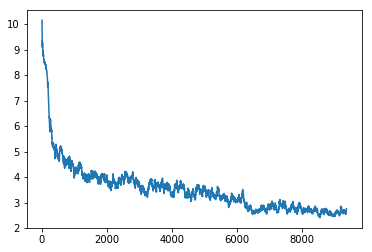

In [42]:
learn.sched.plot_loss()